##Import Libraries and Dataset

In [ ]:
import pandas as pd
import numpy as np

from xgboost import XGBRegressor

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [ ]:
df= pd.read_csv("/content/norway_new_car_sales_by_make.csv")
df

,Year,Month,Make,Quantity,Pct
0,2007,1,Toyota,2884,22.7
1,2007,1,Volkswagen,2521,19.9
2,2007,1,Peugeot,1029,8.1
3,2007,1,Ford,870,6.9
4,2007,1,Volvo,693,5.5
...,...,...,...,...,...
4372,2017,1,Nilsson,3,0.0
4373,2017,1,Maserati,2,0.0
4374,2017,1,Ferrari,1,0.0
4375,2017,1,Smart,1,0.0


In [ ]:
df["Period"] = df["Year"].astype(str) + "-" + df["Month"].astype(str).str.zfill(2)

In [ ]:
df.drop(["Pct", "Year", "Month"],axis=1, inplace=True)

In [ ]:
df= df.pivot_table(index='Make', columns='Period', values='Quantity', fill_value=0)
df

Period,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,...,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01
Make,,,,,,,,,,,,,,,,,,,,,
Alfa Romeo,16,9,21,20,17,21,14,12,15,10,...,3,1,2,1,6,15,3,4,3,6
Aston Martin,0,0,1,0,4,3,3,0,0,0,...,0,0,1,0,0,0,0,0,0,0
Audi,599,498,682,556,630,498,562,590,393,554,...,685,540,551,687,794,688,603,645,827,565
BMW,352,335,365,360,431,477,403,348,271,562,...,1052,832,808,636,1031,1193,1096,1663,866,1540
Bentley,0,0,0,0,0,1,0,0,0,0,...,0,0,1,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Think,2,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Toyota,2884,1885,1833,1300,1866,1620,1901,1783,1303,1648,...,1432,1687,1603,1127,1824,1823,1327,1375,1238,1526
Volkswagen,2521,1517,1428,1257,1934,1531,1777,1665,1373,1941,...,3017,2222,2287,2076,2359,2084,2161,2106,2239,1688


##Define and Split Train & Test Data

In [ ]:
def datasets(df, x_len=12, y_len=1, test_loops=12):
  D= df.values
  rows, periods = D.shape

  loops= periods + 1 - x_len - y_len
  train = []
  for col in range(loops):
    train.append(D[:,col:col + x_len + y_len])
  train = np.vstack(train)
  X_train, Y_train = np.split(train, [-y_len], axis=1)

  if test_loops > 0:
    X_train, X_test = np.split(X_train, [-rows + test_loops], axis= 0)
    Y_train, Y_test = np.split(Y_train, [-rows + test_loops], axis= 0)
  else:
    X_test = D[:, -x_len:]
    Y_test = np.full((X_test.shape[0], y_len), np.nan)
  
  if y_len ==1:
    Y_train = Y_train.ravel()
    Y_test = Y_test.ravel()
  
  return X_train, Y_train, X_test, Y_test

In [ ]:
X_train, Y_train, X_test, Y_test = datasets(df, x_len=12, y_len=1, test_loops=12)

##Adaptive Boosting

In [ ]:
xgbreg = XGBRegressor()
xgbreg.fit(X_train,Y_train)

[22:50:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [ ]:
y_pred= xgbreg.predict(X_test)

In [ ]:
mean_squared_error(y_pred, Y_test, squared= False)

132.2845633896085

In [ ]:
from sklearn.metrics import r2_score
r2_score(Y_test, y_pred)

0.8790820082153362

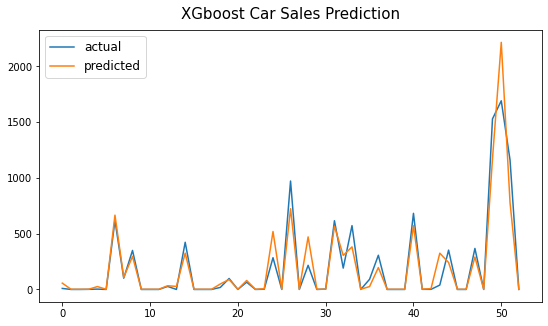

In [ ]:
plt.subplots(figsize=(9,5))
plt.plot(Y_test, label= 'actual')
plt.plot(y_pred, label= 'predicted')
plt.title('XGboost Car Sales Prediction', size=15, y=1.02)
plt.legend(fontsize= 12);

In [ ]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.1, 0.2, 0.3],
    "max_depth": range(3,11),
    "colsample_bytree": np.arange(0.5, 1, 0.1),
    "subsample": np.arange(0.6, 1, 0.1)
    }

# Instantiate a XGboost Regressor:
xgb = XGBRegressor()

# Instantiate the GridSearchCV object: tree_cv
mlp_cv = GridSearchCV(xgb, param_dist, n_jobs=-1)
|
# Fit it to the data
mlp_cv.fit(X_train,Y_train)

# Print the tuned parameters and score
print("Tuned XGboost Parameters: {}".format(mlp_cv.best_params_))

[01:59:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Tuned Adaboost Parameters: {'colsample_bytree': 0.8999999999999999, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}


In [ ]:
optxgb = XGBRegressor(
    learning_rate= mlp_cv.best_params_["learning_rate"],
    n_estimators= mlp_cv.best_params_["n_estimators"],
    max_depth= mlp_cv.best_params_["max_depth"],
    colsample_bytree= mlp_cv.best_params_["colsample_bytree"],
    subsample= mlp_cv.best_params_["subsample"]
)
optxgb.fit(X_train,Y_train)
y_pred= optxgb.predict(X_test)
mean_squared_error(y_pred, Y_test, squared= False)

[01:59:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


137.09240273258152

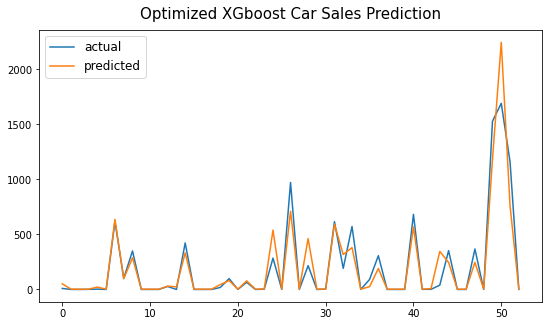

In [ ]:
plt.subplots(figsize=(9,5))
plt.plot(Y_test, label= 'actual')
plt.plot(y_pred, label= 'predicted')
plt.title('Optimized XGboost Car Sales Prediction', size=15, y=1.02)
plt.legend(fontsize= 12);